# Libraries

In [36]:
# Libraries

from pandarallel import pandarallel
import sys
import nltk
import nltk
import ssl
import seaborn as sns
from sentence_transformers import SentenceTransformer

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download("wordnet")
sys.path.append("..")
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from dataclasses import dataclass
from tqdm import tqdm

import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import sys
from flashtext import KeywordProcessor
from constant import MAPPING_OVERALL_TO_SENTIMENT, MAPPING_SENTIMENT_TO_NUMBER

from data_preprocessors.data_cleaner import DataCleaner
from data_preprocessors.spacy_analyzer import SpacyAnalyzer
from data_preprocessors.correction_heuristics_executor import (
    CorrectionHeuristicsExecutor,
)

pandarallel.initialize(progress_bar=True, nb_workers=10)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/arturtanona/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# About dataset

Source: [Kaggle - Amazon Books Reviews](https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews)

This dataset contains approximately 3 million book reviews for 212,404 unique books, along with user information for each review. 

I utilized 1,000,000 rows to conduct the Exploratory Data Analysis (EDA). Let's delve deeply into the data!

In [4]:
# !rm -R ../data
!mkdir -p  ../data

In [5]:
# train_data = next(pd.read_csv("../Books_rating.csv", chunksize=10000, names=['asin', 'title', 'price', 'userId', 'profileName', 'reviewHelpfulness',
#        'overall', 'reviewTime', 'reviewSummary', 'reviewText']))
train_data = pd.read_csv(
    "../Books_rating.csv",
    nrows=1000000,
    names=[
        "asin",
        "title",
        "price",
        "userId",
        "profileName",
        "reviewHelpfulness",
        "overall",
        "reviewTime",
        "reviewSummary",
        "reviewText",
    ],
)

/var/folders/ph/bfnsqjgs6h94fqr63sv1_3t80000gn/T/ipykernel_92101/1199616096.py:3: DtypeWarning: Columns (2,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv("../Books_rating.csv", nrows=1000000,  names=['asin', 'title', 'price', 'userId', 'profileName', 'reviewHelpfulness',


In [6]:
train_data = train_data.dropna().reset_index(drop=True)

# Proprocessing training data

In order to get cleaner text (without typos and unknown words), I have:
- removed duplicated punctuations,
- converted emojis to the word equivalents (e.g. kiss mark),
- removed unknown words from pov of wordnet, 
- removed characters that occur more than 2 times consequtively, 
- converted compound words that are mistakenly written into separate words
etc. 


In [7]:
!rm -R train_spans # clean up resources

The dataset contains 140000 rows. Let's collect infos about lemmas, part of sequence taggings. For this exercise I used SpacyAnalyzer processor, as well as custom CorrectionHeuristicsExecutor. This entire sequence is about reducing effect of typos and misclicks on the quality of the data (I used i.a. Viterbi algorithm).

In [8]:
data_cleaner = DataCleaner(train_data)
data_cleaner.preprocess()
data_cleaner.data = data_cleaner.data[
    ~(data_cleaner.data.reviewText == "")
].reset_index(drop=True)

data_cleaner.data.to_csv("../data//_train_after_cleaning.csv", encoding="utf-8")
analyzer = SpacyAnalyzer(
    path_to_data="../data//_train_after_cleaning.csv",
    chunk_size=30000,
    destination_folder="train_spans",
)
analyzer.extract_spacy_spans()
lemmas = analyzer.collect_info_about_words("lemma")
only_lemmas = [
    word[1] for sequence in lemmas for sentence in sequence for word in sentence
]
only_lemmas = list(set(only_lemmas))
data = pd.read_csv("../data//_train_after_cleaning.csv", index_col=0)
executor = CorrectionHeuristicsExecutor(only_lemmas)
texts = executor.preprocess(data)

06-24 20:11 data_preprocessors.data_cleaner INFO     Words that are uppercase are converted to lowercase


06-24 20:11 data_preprocessors.data_cleaner INFO     Contraction converted to two words sequences


06-24 20:11 data_preprocessors.data_cleaner INFO     HTML characters dropped


06-24 20:11 data_preprocessors.data_cleaner INFO     Emojis dropped


06-24 20:11 data_preprocessors.data_cleaner INFO     Duplicate punctuation removed


06-24 20:11 data_preprocessors.data_cleaner INFO     Removed more than 3 consecutive same characters


06-24 20:11 data_preprocessors.data_cleaner INFO     Add space after punctuation


06-24 20:11 data_preprocessors.data_cleaner INFO     Duplicate spaces removed
06-24 20:11 data_preprocessors.data_cleaner INFO     Cleaning process ended
06-24 20:11 data_preprocessors.spacy_analyzer INFO     Spacy analysis started
100%|███████████████████████| 5/5 [10:23<00:00, 124.69s/it]
06-24 20:21 data_preprocessors.spacy_analyzer INFO     Spacy analysis ended
/var/folders/ph/bfnsqjgs6h94fqr63sv1_3t80000gn/T/ipykernel_92101/3425752862.py:11: DtypeWarning: Columns (3,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../data//_train_after_cleaning.csv', index_col=0)
06-24 20:22 data_preprocessors.correction_heuristics_executor INFO     Words will be corrected into known words or removed
100%|████████████| 140000/140000 [00:20<00:00, 6701.04it/s]
06-24 20:22 data_preprocessors.correction_heuristics_executor INFO     Pipeline ended


In [10]:
with open("default_excluded_words.pkl", "rb") as f:
    correct_word_map_to_none = pickle.load(f)

with open("default_corrected_words.pkl", "rb") as f:
    correct_word_map = pickle.load(f)


text_lemmatized = [
    " ".join(" ".join([word[1].lower() for word in sentence]) for sentence in sequence)
    for sequence in lemmas
]

keyword_processor = KeywordProcessor()


for word, target_word in correct_word_map_to_none.items():
    keyword_processor.add_keyword(word, target_word)
for word, target_word in correct_word_map.items():
    keyword_processor.add_keyword(word, target_word)


new_texts = []
for i in tqdm(text_lemmatized):
    new_texts.append(keyword_processor.replace_keywords(i))

new_texts = [i.lower() for i in new_texts]

100%|████████████| 140000/140000 [00:20<00:00, 6737.44it/s]


In [11]:
data["cleaned sentences"] = texts

In [12]:
len(new_texts)

140000

In [13]:
data.shape

(140000, 11)

In [14]:
data["text_lematized"] = new_texts

In [15]:
data["length"] = train_data.reviewText.str.len()

In [16]:
# removing 30000 outliers
data = data[np.logical_and(data["length"] < 2500, data["length"] > 100)]

In [17]:
data.reset_index(drop=True).to_csv("../data/final_train_data.csv")

In [19]:
train_data.groupby("title").size().sort_values(ascending=False)

title
Hannibal                                                                                     1249
Jane Eyre (New Windmill)                                                                     1190
The Picture of Dorian Gray (Classic Collection (Brilliance Audio))                           1184
The Five Love Languages: The Secret to Love that Lasts                                        985
A Christmas Carol (Classic Fiction)                                                           957
                                                                                             ... 
Information Technology Consulting and Other Professional Services Agreements Line by Line       1
Inheriting Scotland                                                                             1
The Cambridge Companion to Spinoza (Cambridge Companions to Philosophy)                         1
The Cambridge Companion to Renaissance Humanism (Cambridge Companions to Literature)            1
Mind, Brain, a

# Short overview

In [20]:
train_data = pd.read_csv("../data/final_train_data.csv", index_col=0)

Cleaned data contains unique 124601 reviews  on 15103 books. Some of them are spams, some laconic, some are examples of the very good piece of writing. 

In [23]:
len(train_data.reviewText.unique())

124601

In [24]:
len(train_data.title.unique())

15103

In [25]:
print(
    train_data[
        train_data.reviewText.str.len() == train_data.reviewText.str.len().max()
    ].reviewText.values[0][:1000]
)

This new trend in advice books aimed for women has all the sensationalism ( and staying power) of Reality tv or other " yellow" forms of entertainment. i realize the title and writing is sensationalized in order to sell lots of books and make the author a nice pile of royalty checks, is this really an advancement in relationships between the sexes? i wanted to give it one star, but i realize, if you want to play a game along the lines recommended in this book, you can manipulate another human being and keep them in a relationship. But my question is- if you have to resort to such tactics, and if the other person is willing to continuously submit to such tactics, what kind of long- term relationship are you hoping to achieve? Like i posted about another ill- fated book of advice on modern marriage, if i were a divorce lawyer, I would be sending out complimentary copies of this book all across my locale with my name and number affixed to the front cover, and just wait five years. there i

In [26]:
try:
    print(train_data[train_data.reviewText.str.len() < 100].reviewText.values[0][:1000])
except:
    pass

In [27]:
train_data["sentiment"] = train_data["overall"].apply(
    lambda x: MAPPING_OVERALL_TO_SENTIMENT[x]
)

06-24 20:28 matplotlib.category INFO     Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
06-24 20:28 matplotlib.category INFO     Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


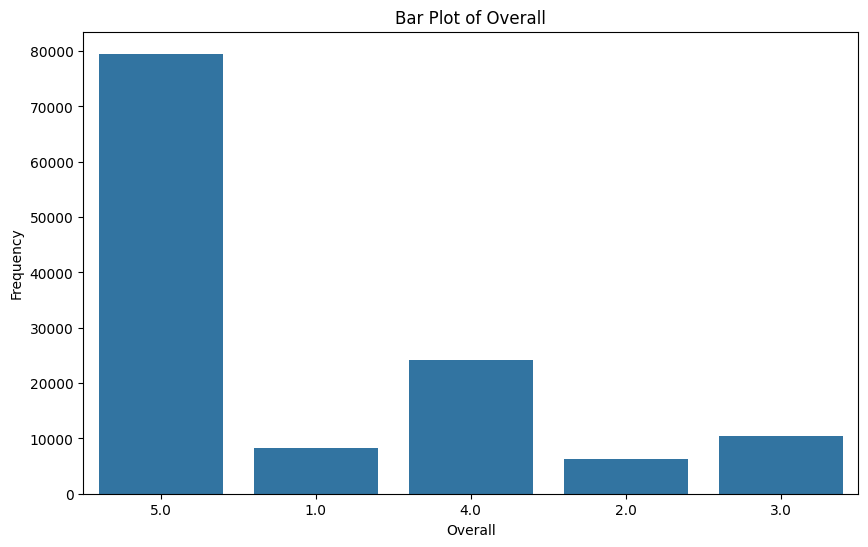

In [39]:
plt.figure(figsize=(10, 6))
sns.countplot(x="overall", data=data)

plt.title("Bar Plot of Overall")
plt.xlabel("Overall")
plt.ylabel("Frequency")
plt.show()

# Vocab analysis

Analysis of vacubalry from part of speech perspective might be useful especielly if we would like to check how the text of the typical review is built.

In [40]:
analyzer = SpacyAnalyzer(
    path_to_data="../data/final_train_data.csv",
    chunk_size=30000,
    destination_folder="../train_spans/",
)
poses = analyzer.collect_info_about_words("pos")

<Axes: ylabel='Frequency'>

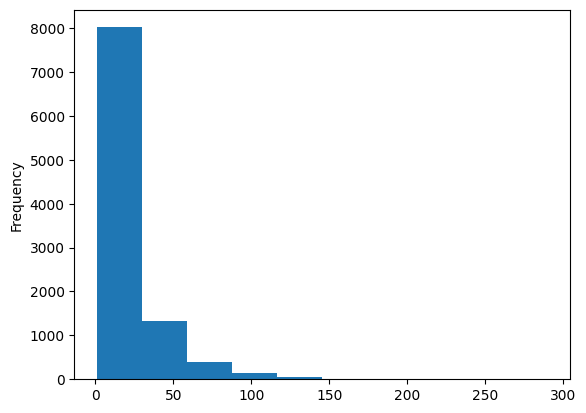

In [41]:
counted_poses = [
    Counter([word[1] for sentence in sequence for word in sentence])
    for sequence in poses
]

counted_poses = [dict(count) for count in counted_poses]

poses_matrix = pd.DataFrame(counted_poses)

poses_matrix["NOUN"].plot.hist()

In [42]:
noun_occurences = [
    word[0]
    for sequence in poses
    for sentence in sequence
    for word in sentence
    if word[1] == "NOUN"
]
verb_occurences = [
    word[0]
    for sequence in poses
    for sentence in sequence
    for word in sentence
    if word[1] == "VERB"
]
adjective_occurences = [
    word[0]
    for sequence in poses
    for sentence in sequence
    for word in sentence
    if word[1] == "ADJ"
]

In [43]:
noun_occurences = Counter(noun_occurences)

In [44]:
results = sorted(dict(noun_occurences), key=lambda x: noun_occurences[x], reverse=True)
{key: noun_occurences[key] for key in results[:30]}

{'book': 12458,
 'story': 7745,
 'characters': 3364,
 'series': 3002,
 'author': 2518,
 'books': 2502,
 'love': 2165,
 'time': 2110,
 'way': 1891,
 'read': 1875,
 'life': 1864,
 'one': 1379,
 'romance': 1280,
 'character': 1153,
 'things': 1097,
 'stories': 1093,
 'lot': 1082,
 'end': 1035,
 'people': 1020,
 'man': 959,
 'world': 951,
 'bit': 920,
 'part': 839,
 'family': 832,
 'review': 808,
 'plot': 803,
 'sex': 785,
 'relationship': 756,
 's': 731,
 'heart': 703}

In [45]:
verb_occurences = Counter(verb_occurences)

In [46]:
results = sorted(dict(verb_occurences), key=lambda x: verb_occurences[x], reverse=True)
{key: verb_occurences[key] for key in results[:30]}

{'read': 5160,
 'have': 2894,
 's': 2613,
 'get': 2332,
 'had': 2085,
 'love': 2044,
 'loved': 1940,
 'reading': 1906,
 'has': 1905,
 'know': 1747,
 'see': 1568,
 'want': 1469,
 'enjoyed': 1468,
 'think': 1312,
 'like': 1281,
 'find': 1275,
 'going': 1241,
 'make': 1234,
 'wait': 1148,
 'written': 1136,
 'recommend': 1103,
 'do': 1094,
 'say': 1042,
 'made': 1032,
 'found': 985,
 'go': 982,
 'liked': 977,
 'put': 959,
 'feel': 918,
 "'": 863}

In [47]:
adjective_occurences = Counter(adjective_occurences)

In [50]:
results = sorted(
    dict(adjective_occurences), key=lambda x: adjective_occurences[x], reverse=True
)
selected_results = {key: adjective_occurences[key] for key in results[:50]}

In [51]:
selected_results

{'more': 3015,
 'good': 2923,
 'great': 2516,
 'other': 2207,
 'first': 1692,
 'little': 1585,
 'short': 1274,
 'next': 1221,
 'many': 1074,
 'new': 1027,
 'hot': 882,
 'interesting': 875,
 'much': 833,
 'different': 832,
 'best': 789,
 'own': 784,
 'few': 775,
 'real': 682,
 'bad': 679,
 'easy': 671,
 'sure': 617,
 'main': 570,
 'better': 567,
 'old': 532,
 'sweet': 530,
 'last': 521,
 'amazing': 519,
 'wonderful': 518,
 'young': 514,
 'same': 513,
 'sexy': 504,
 'whole': 499,
 'able': 486,
 'happy': 482,
 'honest': 479,
 'enough': 471,
 'nice': 461,
 'perfect': 459,
 'hard': 458,
 'strong': 458,
 'free': 447,
 'worth': 447,
 'full': 441,
 'second': 439,
 'most': 422,
 'only': 416,
 'true': 400,
 'quick': 392,
 'beautiful': 376,
 'big': 361}

Definetely some of the words should be removed because they won't indicate any topic and they can remove the advanteges of TFiDF vectorizer. 

# Vocabulary analysis per ngram and sentiment type. 

Let's analyse corpus for mixed, negative and positive reviews from this perspective.

## Positive ngrams

In [52]:
@dataclass
class VectorizerData:
    ngram: int
    sentiment: str
    vectorizer: CountVectorizer
    sum_words: np.array
    words_freq: np.array

In [53]:
with open("stopwords-en.txt") as f:
    stop_words = f.read().splitlines()

In [54]:
def get_top_ngram(sentiment, n=None):
    # https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools
    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words=stop_words)
    bag_of_words = vectorizer.fit_transform(
        train_data[train_data.sentiment == sentiment]["reviewText"]
    )
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [
        (word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()
    ]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return VectorizerData(
        ngram=n,
        sentiment=sentiment,
        vectorizer=vectorizer,
        sum_words=sum_words,
        words_freq=words_freq,
    )

In [55]:
positive_1_gram = get_top_ngram("positive", 1)

/Users/arturtanona/Documents/coursera/unsupervised-machine-learning/week4/old-one/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['herse', 'himse', 'itse', 'mon', 'myse', 'positivea'] not in stop_words.
  warnings.warn(


<Axes: >

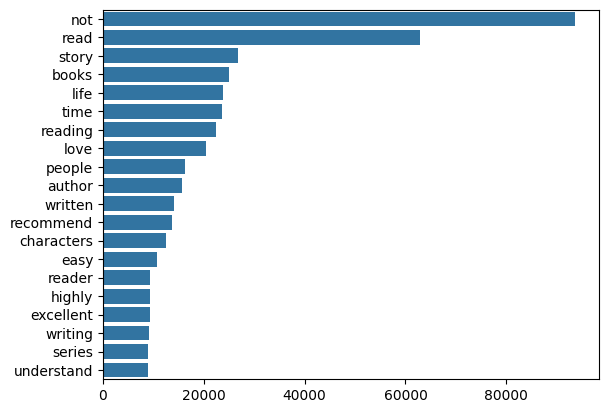

In [56]:
x, y = map(list, zip(*positive_1_gram.words_freq[:20]))
sns.barplot(x=y, y=x)

In [57]:
positive_2_gram = get_top_ngram("positive", 2)

/Users/arturtanona/Documents/coursera/unsupervised-machine-learning/week4/old-one/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['herse', 'himse', 'itse', 'mon', 'myse', 'positivea'] not in stop_words.
  warnings.warn(


<Axes: >

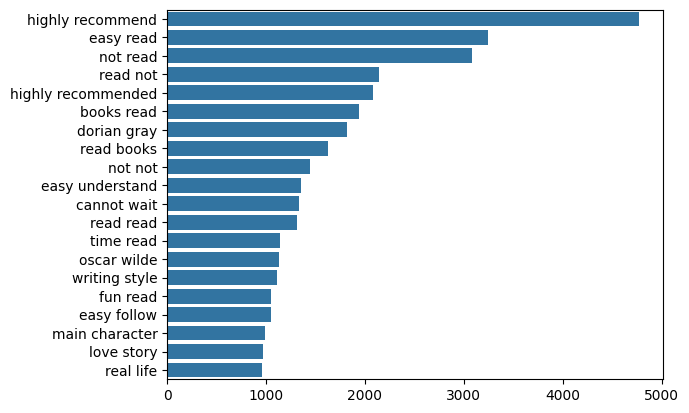

In [58]:
x, y = map(list, zip(*positive_2_gram.words_freq[:20]))
sns.barplot(x=y, y=x)

In [59]:
positive_3_gram = get_top_ngram("positive", 3)

/Users/arturtanona/Documents/coursera/unsupervised-machine-learning/week4/old-one/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['herse', 'himse', 'itse', 'mon', 'myse', 'positivea'] not in stop_words.
  warnings.warn(


<Axes: >

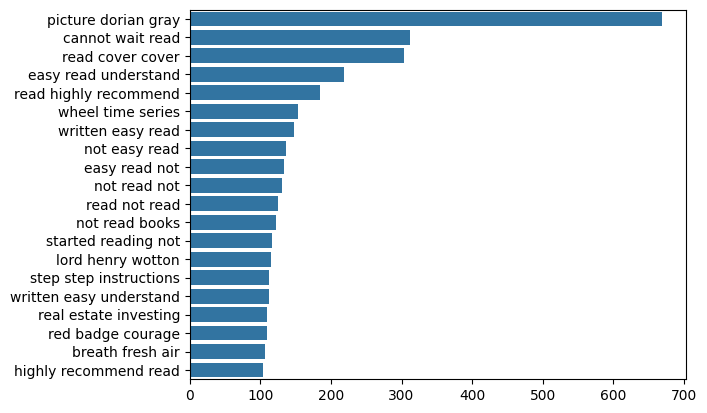

In [60]:
x, y = map(list, zip(*positive_3_gram.words_freq[:20]))
sns.barplot(x=y, y=x)

## Negative ngrams

In [61]:
negative_1_gram = get_top_ngram("negative", 1)

/Users/arturtanona/Documents/coursera/unsupervised-machine-learning/week4/old-one/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['herse', 'himse', 'itse', 'mon', 'myse', 'positivea'] not in stop_words.
  warnings.warn(


<Axes: >

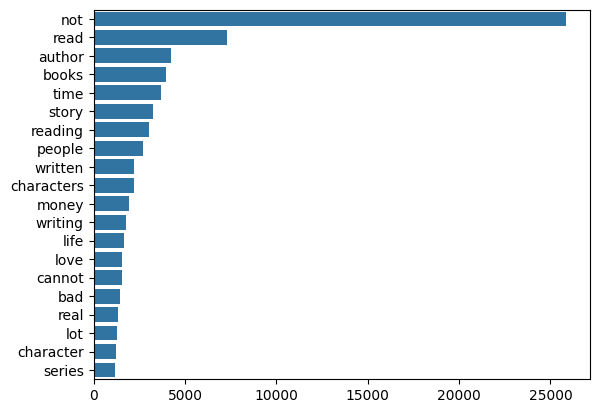

In [62]:
x, y = map(list, zip(*negative_1_gram.words_freq[:20]))
sns.barplot(x=y, y=x)

In [63]:
negative_2_gram = get_top_ngram("negative", 2)

/Users/arturtanona/Documents/coursera/unsupervised-machine-learning/week4/old-one/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['herse', 'himse', 'itse', 'mon', 'myse', 'positivea'] not in stop_words.
  warnings.warn(


<Axes: >

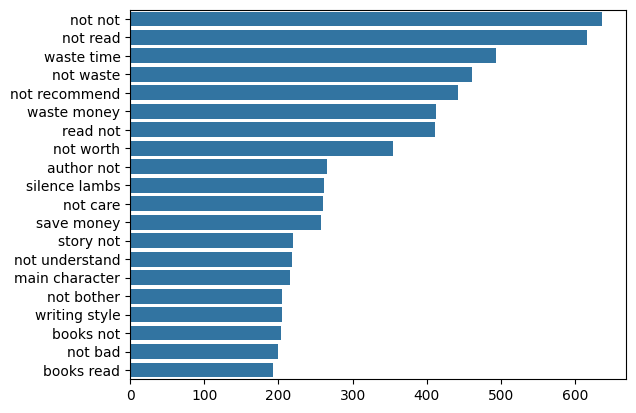

In [64]:
x, y = map(list, zip(*negative_2_gram.words_freq[:20]))
sns.barplot(x=y, y=x)

In [65]:
negative_3_gram = get_top_ngram("negative", 3)

/Users/arturtanona/Documents/coursera/unsupervised-machine-learning/week4/old-one/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['herse', 'himse', 'itse', 'mon', 'myse', 'positivea'] not in stop_words.
  warnings.warn(


<Axes: >

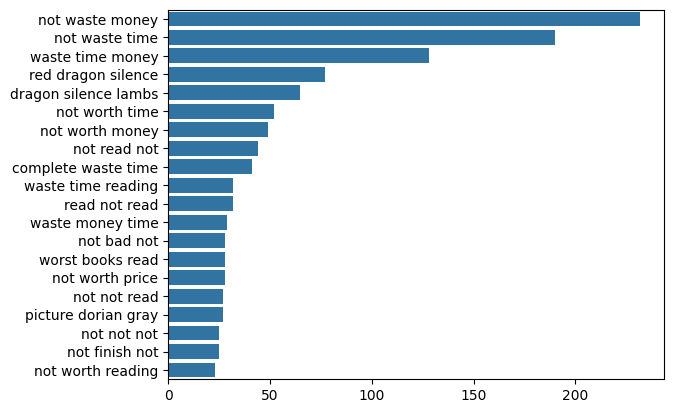

In [66]:
x, y = map(list, zip(*negative_3_gram.words_freq[:20]))
sns.barplot(x=y, y=x)

## Mixed ngrams

In [67]:
mixed_1_gram = get_top_ngram("mixed", 1)

/Users/arturtanona/Documents/coursera/unsupervised-machine-learning/week4/old-one/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['herse', 'himse', 'itse', 'mon', 'myse', 'positivea'] not in stop_words.
  warnings.warn(


<Axes: >

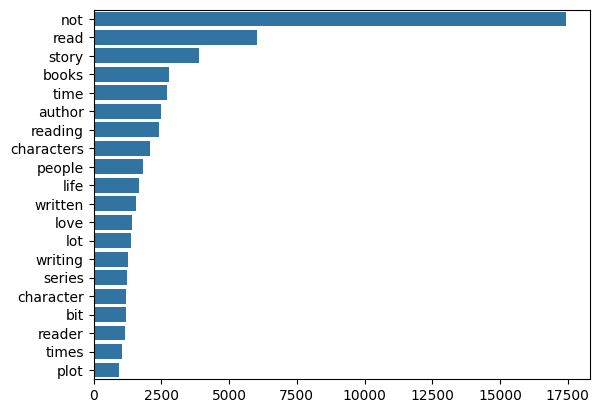

In [68]:
x, y = map(list, zip(*mixed_1_gram.words_freq[:20]))
sns.barplot(x=y, y=x)

In [69]:
mixed_2_gram = get_top_ngram("mixed", 2)

/Users/arturtanona/Documents/coursera/unsupervised-machine-learning/week4/old-one/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['herse', 'himse', 'itse', 'mon', 'myse', 'positivea'] not in stop_words.
  warnings.warn(


<Axes: >

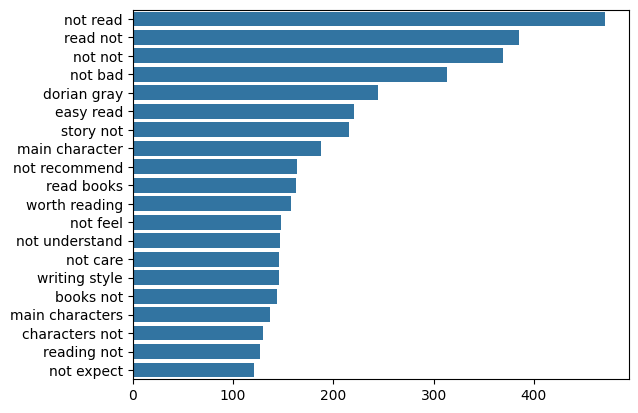

In [70]:
x, y = map(list, zip(*mixed_2_gram.words_freq[:20]))
sns.barplot(x=y, y=x)

In [71]:
mixed_3_gram = get_top_ngram("mixed", 3)

/Users/arturtanona/Documents/coursera/unsupervised-machine-learning/week4/old-one/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['herse', 'himse', 'itse', 'mon', 'myse', 'positivea'] not in stop_words.
  warnings.warn(


<Axes: >

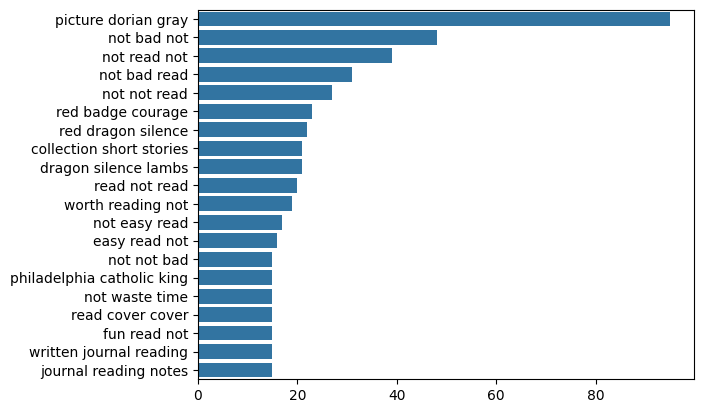

In [72]:
x, y = map(list, zip(*mixed_3_gram.words_freq[:20]))
sns.barplot(x=y, y=x)

# Other features

In [73]:
train_data["total_length"] = train_data["reviewText"].apply(lambda x: len(x))
train_data["num_exclamation_marks"] = train_data["reviewText"].apply(
    lambda comment: comment.count("!")
)
train_data["num_question_marks"] = train_data["reviewText"].apply(
    lambda comment: comment.count("?")
)
train_data["num_punctuation"] = train_data["reviewText"].apply(
    lambda comment: sum(comment.count(w) for w in ".,;:")
)
train_data["num_symbols"] = train_data["reviewText"].apply(
    lambda comment: sum(comment.count(w) for w in "*&$%")
)

In [74]:
train_data["mapped_sentiment"] = train_data["sentiment"].apply(
    lambda x: MAPPING_SENTIMENT_TO_NUMBER[x]
)

In [75]:
corr = train_data[train_data["sentiment"].isin(["positive", "negative"])][
    [
        "total_length",
        "num_exclamation_marks",
        "num_question_marks",
        "num_punctuation",
        "num_symbols",
        "mapped_sentiment",
    ]
].corr()

06-24 20:30 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x4a81cfee0>


<Axes: >

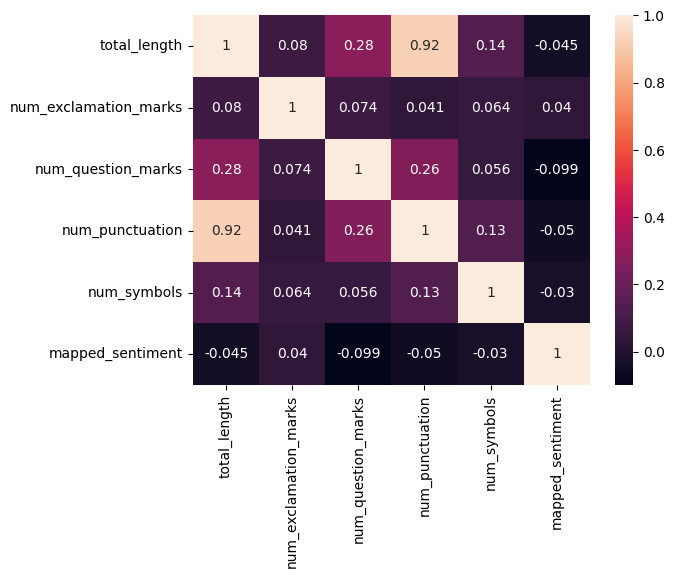

In [76]:
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True)

Source of idea; https://www.kaggle.com/nz0722/simple-eda-text-preprocessing-jigsaw

# Lengths

Most of the reviews are between 500-1000 characters length.

In [77]:
lengths = train_data.reviewText.apply(lambda x: len(x.split()))

<Axes: ylabel='Frequency'>

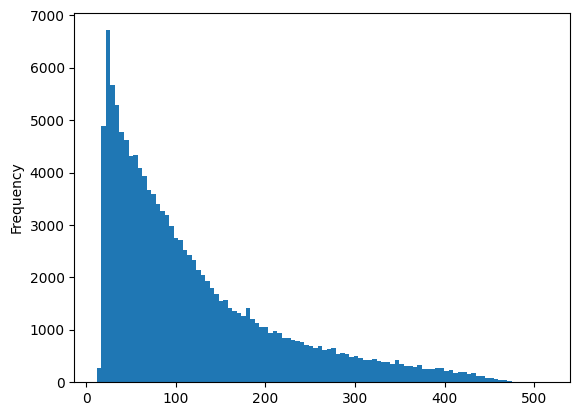

In [78]:
lengths.plot.hist(bins=100)

In [79]:
train_data["lengths"] = lengths

In [80]:
train_data = train_data[train_data["lengths"] < 1000].reset_index(drop=True)

In [81]:
train_data = train_data[
    (1000 > train_data["lengths"]) & (train_data["lengths"] > 10)
].reset_index(drop=True)

In [82]:
train_data.to_csv("../data/final_train_data.csv")

# Next steps - topic modelling with unsupervised ML algorithm!

Punctuation is important from the perspective of sentence embedding transformer - it can change the entire context of information. On the other hand, in the traditional ML (e.g. TfIDF) it should be pruned. So let's TFIDF-vectorize data and train some topic model.


Topic modeling is a statistical approach in machine learning and natural language processing designed to uncover abstract topics within a set of documents. These models facilitate the exploration and comprehension of extensive text data by detecting patterns in word co-occurrence.

There are many applications for topic modeling. In information retrieval, it enhances search results by organizing and grouping related documents. In recommendation systems, it improves user experience by suggesting content based on identified themes. Additionally, it is utilized in social media analysis to measure public sentiment and trends by pinpointing common topics in user-generated content. This can answer the following question:

## What topics get the worst reviews? 